<a href="https://colab.research.google.com/github/MiamiCrypto/Sports-Analytics-/blob/main/mdc_value_per_minute_report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🏀 MDC Women's Basketball Analytics (2024–25)
## Report Focus: Maximizing Value per Minute Played

This notebook analyzes individual player contributions for the MDC Women's Basketball Team during the 2024–25 season.  
The focus is to identify players who provide high value despite receiving limited playing time — highlighting opportunities for optimizing rotations and player development.

Key metrics used:
- OBPR (Offensive Bayesian Performance Rating)
- DBPR (Defensive Bayesian Performance Rating)
- BPR = OBPR + DBPR (Total box-based impact score)
- Per-36 minute performance (Points, Assists, Rebounds)

### 🧱 Step 1: Load and Prepare Data

We loaded two cleaned datasets from GitHub:
- `player_season_stats_2024_25_cleaned.csv` – individual season stats per player.
- `mdc_roster_2024_25_cleaned.csv` – player roster info such as position and class year.

We merged them using the `player_name` column to create a unified dataset for analysis.

Light preprocessing was applied:
- Trimmed whitespace from player names.
- Filled missing values with `0` to avoid errors during calculation.

✅ This unified DataFrame will be the foundation for all future metrics and visualizations.

In [2]:
import pandas as pd

# Load player season stats
stats_url = "https://raw.githubusercontent.com/MiamiCrypto/Sports-Analytics-/refs/heads/main/mdc_value_per_minute_report/player_season_stats_2024_25_cleaned.csv"
df_stats = pd.read_csv(stats_url)

# Load roster info
roster_url = "https://raw.githubusercontent.com/MiamiCrypto/Sports-Analytics-/refs/heads/main/mdc_value_per_minute_report/mdc_roster_2024_25_cleaned.csv"
df_roster = pd.read_csv(roster_url)

# Merge on player name (you can switch to 'id' if needed)
df = pd.merge(df_stats, df_roster, on='player_name', how='left')

# Light cleanup: remove trailing/leading spaces, handle nulls if necessary
df['player_name'] = df['player_name'].str.strip()
df = df.fillna(0)  # optional: fill missing with 0 for numeric calculations

# Show quick preview
df.head()

,#,player_name,gp,gs,min,avg_min,fg,fga,fg_pct,3fg,...,to_g,a_to_ratio,blk,blk_g,stl,stl_g,pts,avg_p,class_year,position
0,15,Shameir Quimby,31,30,795,25.6,241,496,48.6,2,...,2.3,1.9,8,0.3,81,2.6,597,19.3,Sophomore,G
1,23,Clearia Peterson,31,31,723,23.3,231,477,48.4,9,...,2.7,0.6,24,0.8,47,1.5,560,18.1,Freshman,F/C
2,21,Kiara Harris,31,31,774,25.0,155,389,39.8,98,...,3.1,1.2,6,0.2,91,2.9,465,15.0,Freshman,G
3,2,Jazmyne Bynum,31,25,600,19.4,166,461,36.0,71,...,2.7,1.0,1,0.0,60,1.9,453,14.6,Freshman,G
4,8,Michaela Lane,28,19,485,17.3,74,173,42.8,0,...,1.9,1.0,45,1.6,28,1.0,175,6.3,Sophomore,C


## 🧮 Step 2 – Calculate OBPR, DBPR, and BPR

We now create three key performance indicators that summarize each player's impact:

- **OBPR (Offensive Bayesian Performance Rating):** A composite offensive value score using points, assists, turnovers, and shooting efficiency.
- **DBPR (Defensive Bayesian Performance Rating):** A defensive score using steals, blocks, rebounds, and fouls.
- **BPR (Bayesian Performance Rating):** The total performance value calculated by summing OBPR and DBPR.

These box score–based formulas give us an objective way to rank and compare overall player impact.

In [3]:
# Calculate OBPR (Offensive Bayesian Performance Rating)
df['box_obpr'] = (
    df['avg_p'] * 0.5 +
    df['assist'] / df['gp'] * 1.2 -
    df['to'] / df['gp'] * 1.0 +
    df['fg_pct'] * 0.1 +
    df['ft_pct'] * 0.05 +
    df['3fga'] * 0.02
).round(2)

# Calculate DBPR (Defensive Bayesian Performance Rating)
df['box_dbpr'] = (
    df['stl'] / df['gp'] * 1.5 +
    df['blk'] / df['gp'] * 1.5 +
    df['totr'] / df['gp'] * 0.5 -
    df['pfoul'] / df['gp'] * 0.5
).round(2)

# Combine to get overall BPR
df['box_bpr'] = (df['box_obpr'] + df['box_dbpr']).round(2)

# Preview new columns
df[['player_name', 'box_obpr', 'box_dbpr', 'box_bpr']].sort_values(by='box_bpr', ascending=False)

,player_name,box_obpr,box_dbpr,box_bpr
0,Shameir Quimby,21.24,7.42,28.66
2,Kiara Harris,22.04,5.06,27.10
1,Clearia Peterson,16.88,8.05,24.93
3,Jazmyne Bynum,19.50,3.18,22.68
4,Michaela Lane,10.85,6.68,17.53
5,Jamesha Card,10.96,2.20,13.16
6,Abigail Alvarez,8.61,0.75,9.36
7,KaMariya Simmons,6.91,2.29,9.20
8,Aliana Bass,3.58,0.04,3.62


## 📊 Step 3 – BPR vs. Minutes Played

This scatterplot compares each player’s total minutes played to their calculated BPR (Box-Based Performance Rating).

### 📌 Why It Matters:
- Players with high BPR but low minutes are potential hidden assets.
- Helps identify players who could have a larger impact if given more playing time.

<ipython-input-4-5a8401f6759c>:16: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


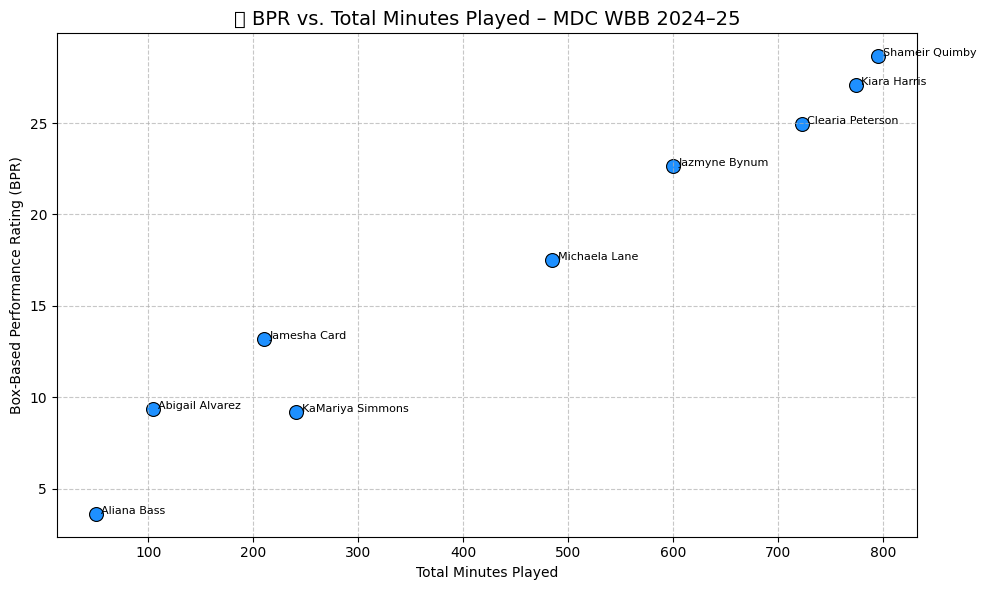

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot BPR vs Minutes
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='min', y='box_bpr', s=100, color='dodgerblue', edgecolor='black')

# Annotate each point with player names
for i, row in df.iterrows():
    plt.text(row['min'] + 5, row['box_bpr'], row['player_name'], fontsize=8)

plt.title("📈 BPR vs. Total Minutes Played – MDC WBB 2024–25", fontsize=14)
plt.xlabel("Total Minutes Played")
plt.ylabel("Box-Based Performance Rating (BPR)")
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 📊 Insight: BPR vs. Total Minutes Played – MDC WBB 2024–25

This chart plots each player’s total **Box-Based Performance Rating (BPR)** against their **total minutes played**, offering a visual understanding of efficiency versus opportunity.

#### Key Findings:
- **Shameir Quimby**, **Kiara Harris**, and **Clearia Peterson** are top performers with both high BPR and high minutes, confirming their status as core contributors.
- **Jamesha Card** and **Abigail Alvarez** have solid BPR scores despite lower total minutes, indicating underutilized potential.
- **Aliana Bass** shows low BPR and low minutes, suggesting limited current impact and highlighting an opportunity for skill development.

#### Coaching Value:
This analysis helps the coaching staff:
- Validate the high usage of top performers.
- Identify **players with high impact per minute** who may deserve more playing time.
- Spot developmental players who may benefit from targeted training or low-pressure game experience.

### 📊 Step 4: Stacked Column Chart – BPR Contribution by Class Year

The current chart shows each player's total Box-Based Performance Rating (BPR) broken down by class year, but it's displayed in alphabetical order, which may obscure key performance trends.

To improve clarity:
- Players should be **sorted by total BPR** to highlight top contributors.
- Optionally, display a **true stacked bar chart** with class year totals, allowing a clean comparison between cohorts (Freshmen vs. Sophomores).
This refinement will better communicate who is driving team impact and how experience level influences performance.
.

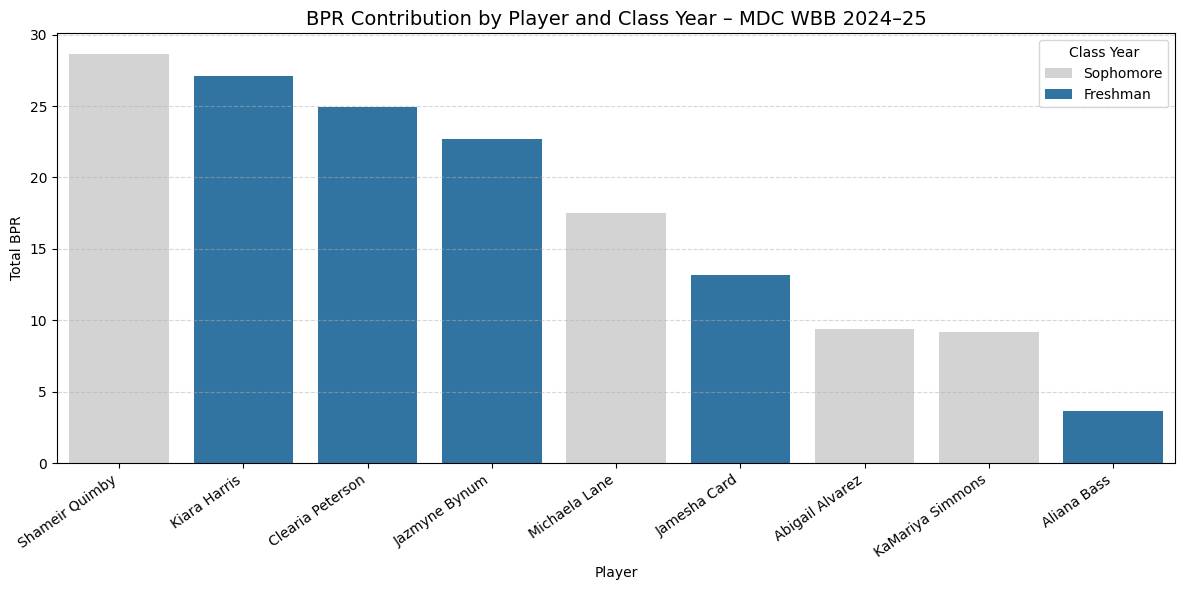

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define custom palette using MDC school colors
custom_palette = {
    'Freshman': '#1f77b4',   # MDC Blue
    'Sophomore': '#d3d3d3'   # Light Gray (white alternative for clarity)
}

# Sort data by BPR
df_sorted = df.sort_values(by='box_bpr', ascending=False)

# Set figure size
plt.figure(figsize=(12, 6))

# Plot grouped bar chart with custom colors
sns.barplot(
    data=df_sorted,
    x='player_name',
    y='box_bpr',
    hue='class_year',
    dodge=False,
    palette=custom_palette
)

# Titles and labels
plt.title("BPR Contribution by Player and Class Year – MDC WBB 2024–25", fontsize=14)
plt.xlabel("Player")
plt.ylabel("Total BPR")
plt.xticks(rotation=35, ha='right')
plt.legend(title="Class Year")
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

## 🧩 Visual 2: BPR Contribution by Player and Class Year – MDC WBB 2024–25

This grouped bar chart ranks all players by their total BPR (Box-Based Performance Rating), color-coded by class year (Freshman vs. Sophomore). It reveals not only who the top performers are, but also highlights the balance of contributions between experienced and newer players.

**Key Insights:**
- **Top 4 contributors (Shameir Quimby, Kiara Harris, Clearia Peterson, Jazmyne Bynum)** account for a significant portion of the team’s overall value.
- **Freshmen players** dominate the top 5 BPR contributors, signaling strong future potential.
- Some **sophomores (e.g., Aliana Bass, KaMariyah Simmons)** show relatively low BPR values, highlighting development opportunities.
- The team appears to be **less reliant on class seniority** and more on individual performance.

This visual helps coaches assess current lineup strength and determine which class years may need more development or support moving forward.

## 🔵 Visual 3: OBPR vs. DBPR – Offensive vs. Defensive Value Scatterplot
This scatterplot compares each player’s Offensive Bayesian Performance Rating (OBPR) and Defensive Bayesian Performance Rating (DBPR) to visualize the balance of contributions on both ends of the floor.

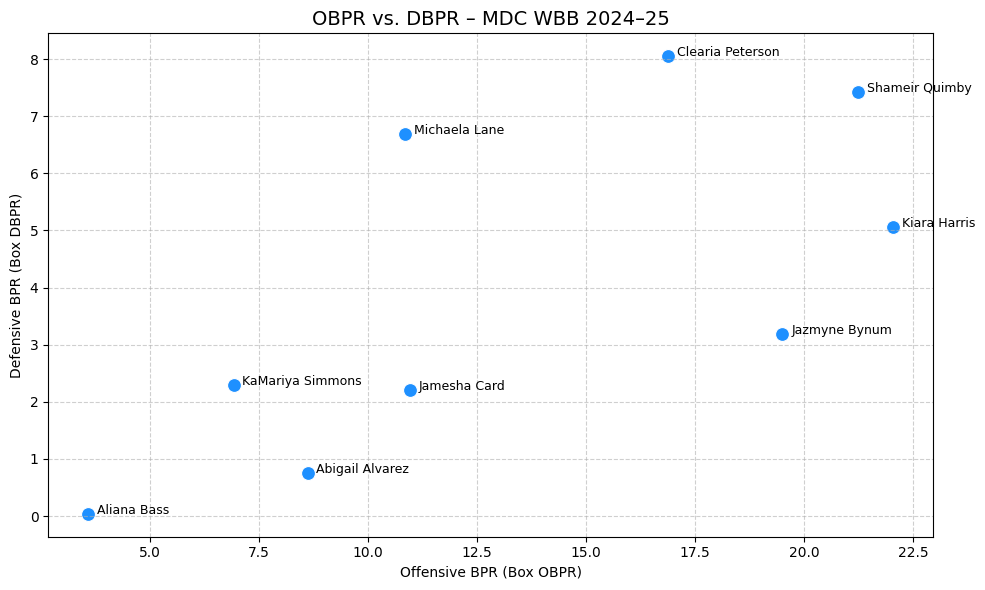

In [9]:
# Scatterplot of OBPR vs. DBPR
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='box_obpr', y='box_dbpr', s=100, color='dodgerblue')

# Annotate player names
for _, row in df.iterrows():
    plt.text(row['box_obpr'] + 0.2, row['box_dbpr'], row['player_name'], fontsize=9)

plt.title("OBPR vs. DBPR – MDC WBB 2024–25", fontsize=14)
plt.xlabel("Offensive BPR (Box OBPR)")
plt.ylabel("Defensive BPR (Box DBPR)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## 🔍 Insight:
Shameir Quimby and Clearia Peterson emerge as the most balanced high-impact players, excelling in both offensive and defensive metrics.

Kiara Harris and Jazmyne Bynum show high offensive value but more modest defensive ratings, suggesting their strengths lie in scoring and playmaking.

Michaela Lane demonstrates strong defensive performance with a lower offensive contribution, representing a defensive specialist role.

Players in the lower-left quadrant, such as Aliana Bass and KaMariyah Simmons, offer limited impact in both areas and could be targets for focused development or adjusted minutes.

This chart supports strategic roster decisions by clearly identifying players who bring two-way value versus those who contribute more selectively.